In [1]:
from sklearn.linear_model import LogisticRegression as lr
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import networkx as nx
from networkx.algorithms.tree.branchings import maximum_branching
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [9]:
def get_treatment_level(input):
    if input < 2:
        return 0
    elif input < 10:
        return 1
    elif input < 50:
        return 2
    else:
        return 3

def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

def plot_propensity_plots(predictions, predictions_logit, T):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
    sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
    ax[0].set_title('Propensity Score')
    sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
    ax[1].axvline(-0.4, ls='--')
    ax[1].set_title('Logit of Propensity Score')
    plt.show()

def create_maximum_branching_graph(df_data):
    G = nx.Graph()
    G.add_nodes_from(df_data.reset_index()['osward'].tolist())
    df_data_no_index = df_data.reset_index()
    epsilon = 0.0001
    for index, row in df_data_no_index.iterrows():
        other_rows = df_data_no_index[df_data_no_index['treatment'] != row.treatment]
        for o_index, o_row in other_rows.reset_index().iterrows():
            modified_distance = (abs(row.propensity_score_logit - o_row.propensity_score_logit) + epsilon) / abs(row.treatment - o_row.treatment)
            if not G.has_edge(row.osward, o_row.osward):
                G.add_edge(row.osward, o_row.osward, weight=modified_distance)
    return maximum_branching(G)

def plot_correlation(input_data, treatment_column):
    correlation = input_data[[treatment_column, 'outcome']]
    correlation.plot.scatter(x=treatment_column, y='outcome')
    spear_corr = stats.spearmanr(list(correlation[treatment_column]), list(correlation['outcome']))
    print('Spearman correlation:', spear_corr.correlation, 'p-value:', spear_corr.pvalue)

def plot_distance_distribution(edmonds_applied, df_data):
    distances = []
    treatment_effect = []
    for (u,v) in edmonds_applied.edges():
        distances.append(abs(df_data['treatment'][u] - df_data['treatment'][v]))
        effect = (df_data['outcome'][u] - df_data['outcome'][v])/(df_data['treatment'][u] - df_data['treatment'][v])
        treatment_effect.append(effect)
    distribution_data = pd.DataFrame(list(zip(distances,treatment_effect)), columns = ['Distance', 'Effect'])
    sns.jointplot(distribution_data, x='Distance', y='Effect', kind='kde', fill=True)

def print_distance_confusion_matrix(edmonds_applied, df_data):
    low_dose_units = []
    high_dose_units = []

    for (u,v) in edmonds_applied.edges():
        u_treatment = df_data['treatment'][u]
        v_treatment = df_data['treatment'][v]
        if u_treatment > v_treatment:
            low_dose_units.append(v_treatment)
            high_dose_units.append(u_treatment)
            continue
        low_dose_units.append(u_treatment)
        high_dose_units.append(v_treatment)

    print(confusion_matrix(high_dose_units, low_dose_units))

def obtain_results(input_data, treatment_column, columns_to_drop):
    subset = input_data.drop(columns_to_drop, axis=1)
    input_data[treatment_column] = input_data[treatment_column].astype('int')
    subset[treatment_column] = subset[treatment_column].astype('int')
    treatment_levels = [get_treatment_level(x) for x in list(input_data[treatment_column])]
    subset_treatment_levels = [get_treatment_level(x) for x in list(subset[treatment_column])]
    input_data[treatment_column + '_bin'] = treatment_levels
    subset[treatment_column] = subset_treatment_levels

    T = subset[treatment_column]
    X = subset.loc[:,subset.columns != treatment_column]
    y = input_data[['TOTAL_QUANTITY']]

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_classifier', lr())
    ])
    pipe.fit(X, T)

    predictions = pipe.predict_proba(X)
    predictions_binary = pipe.predict(X)
    print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
    print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
    print('F1 score is:', metrics.f1_score(T, predictions_binary, average=None))
    predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])
    plot_propensity_plots(predictions, predictions_logit, T)
    input_data.loc[:,'propensity_score'] = predictions[:,1]
    input_data.loc[:,'propensity_score_logit'] = predictions_logit
    input_data.loc[:,'outcome'] = y.TOTAL_QUANTITY

    X.loc[:,'propensity_score'] = predictions[:,1]
    X.loc[:,'propensity_score_logit'] = predictions_logit
    X.loc[:,'outcome'] = y.TOTAL_QUANTITY
    X.loc[:,'treatment'] = input_data[treatment_column + '_bin']

    caliper = np.std(input_data.propensity_score) * 0.25
    print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

    df_data = X
    knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
    knn.fit(df_data[['propensity_score_logit']].to_numpy())
    
    distances , indexes = knn.kneighbors(
        df_data[['propensity_score_logit']].to_numpy(), \
        n_neighbors=10)
    
    edmonds_applied = create_maximum_branching_graph(df_data)
    nx.draw(edmonds_applied)

    plot_correlation(input_data, treatment_column)
    plot_distance_distribution(edmonds_applied, df_data)
    print_distance_confusion_matrix(edmonds_applied, df_data)   

In [10]:
full_dataset_confounders_2014 = pd.read_csv('processed_data/full_dataset_confounders_2014.csv')
full_dataset_confounders_2015 = pd.read_csv('processed_data/full_dataset_confounders_2015.csv')
full_dataset_confounders_2016 = pd.read_csv('processed_data/full_dataset_confounders_2016.csv')

full_dataset_confounders_2014.set_index('osward', inplace=True)
full_dataset_confounders_2015.set_index('osward', inplace=True)
full_dataset_confounders_2016.set_index('osward', inplace=True)

all_columns_to_drop = ['arts_count', 'cinema_count', 'gallery_count',
'comm_center_count', 'dance_count', 'lgbt_count', 'library_count', 'museum_count', 'music_count', 'outdoor_count',
'pub_count', 'skate_count', 'theatre_count', 'total_count', 'TOTAL_QUANTITY']
all_columns_to_drop_year = [x for x in all_columns_to_drop if x != "total_count"]
all_columns_to_drop_arts = [x for x in all_columns_to_drop if x != "arts_count"]
all_columns_to_drop_cinema = [x for x in all_columns_to_drop if x != "cinema_count"]
all_columns_to_drop_gallery = [x for x in all_columns_to_drop if x != "gallery_count"]
all_columns_to_drop_comm_center = [x for x in all_columns_to_drop if x != "comm_center_count"]
all_columns_to_drop_dance = [x for x in all_columns_to_drop if x != "dance_count"]
all_columns_to_drop_lgbt = [x for x in all_columns_to_drop if x != "lgbt_count"]
all_columns_to_drop_library = [x for x in all_columns_to_drop if x != "library_count"]
all_columns_to_drop_museum = [x for x in all_columns_to_drop if x != "museum_count"]
all_columns_to_drop_music = [x for x in all_columns_to_drop if x != "music_count"]
all_columns_to_drop_outdoor = [x for x in all_columns_to_drop if x != "outdoor_count"]
all_columns_to_drop_pub = [x for x in all_columns_to_drop if x != "pub_count"]
all_columns_to_drop_skate = [x for x in all_columns_to_drop if x != "skate_count"]
all_columns_to_drop_theatre = [x for x in all_columns_to_drop if x != "theatre_count"]

# 2014 total

Accuracy: 0.6981

Confusion matrix:
[[  1  25   1   0]
 [  0 307  27   0]
 [  0 112  85   1]
 [  0   3   4   7]]

F1 score is: [0.07142857 0.78617157 0.53968254 0.63636364]


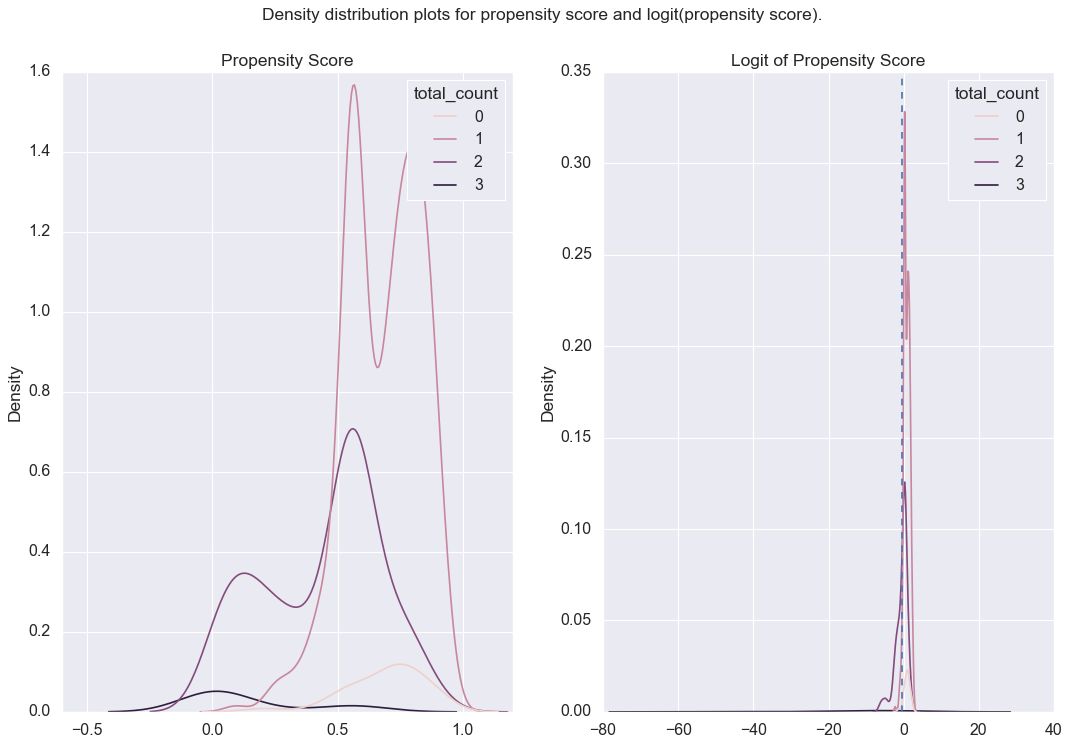


Caliper (radius) is: 0.0578

Spearman correlation: 0.05106723267395223 p-value: 0.22225841545671005
[[  0   0   0   0]
 [  1   0   0   0]
 [  2  72   0   0]
 [ 24 277 196   0]]


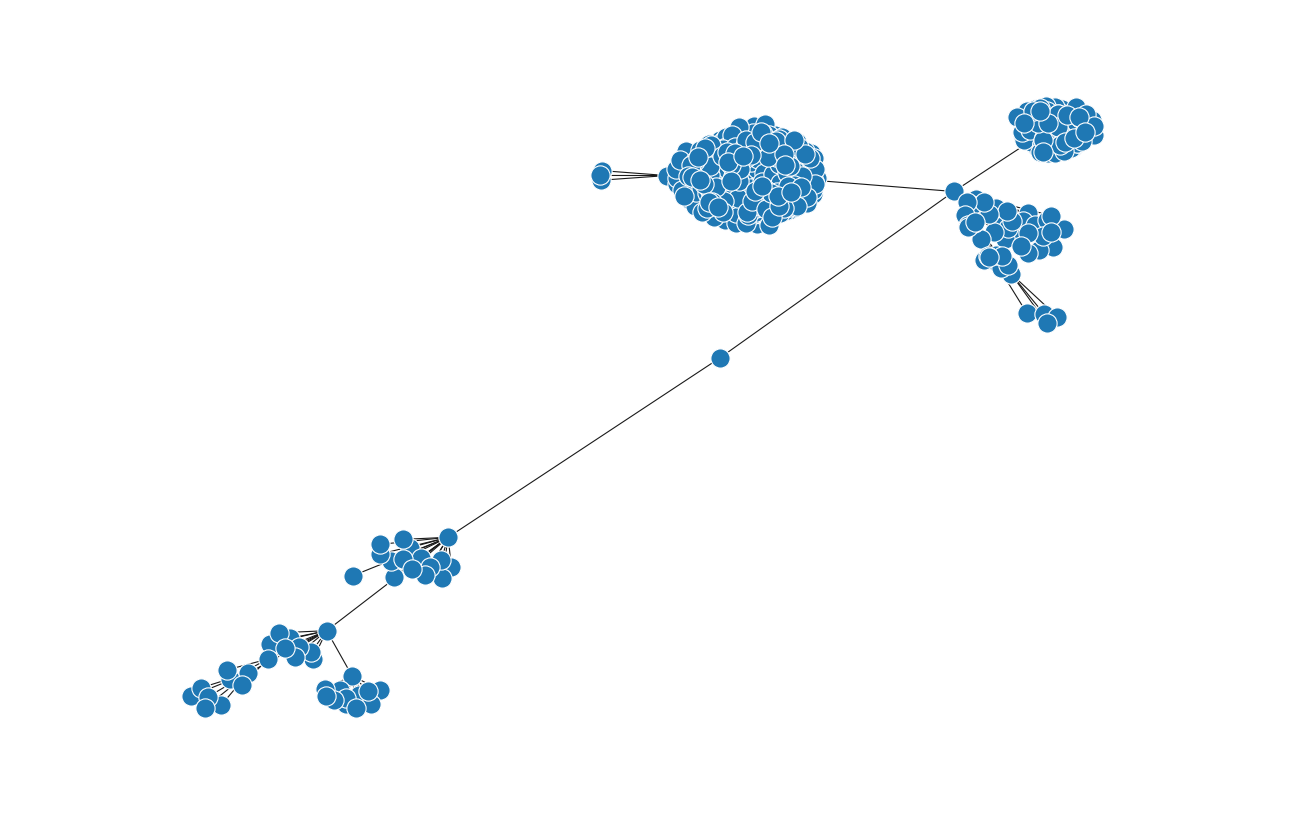

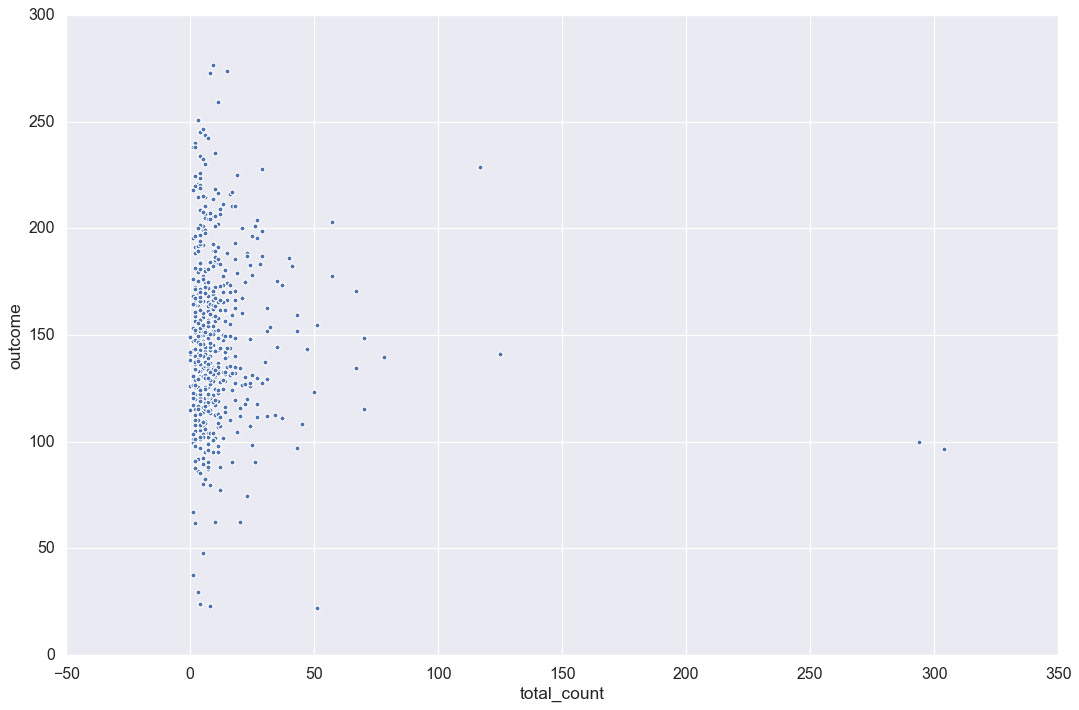

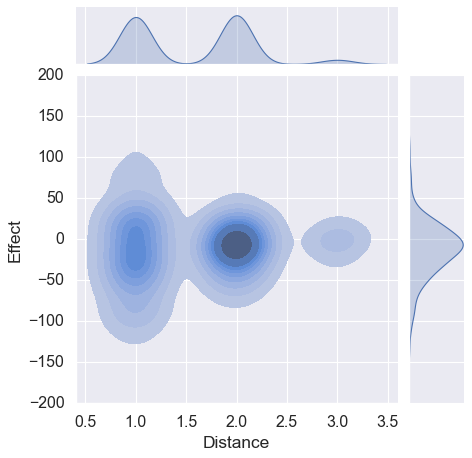

In [11]:
#2014 total

obtain_results(full_dataset_confounders_2014, 'total_count', all_columns_to_drop_year)

# 2015 total

Accuracy: 0.6981

Confusion matrix:
[[  1  25   1   0]
 [  0 307  27   0]
 [  0 112  85   1]
 [  0   3   4   7]]

F1 score is: [0.07142857 0.78617157 0.53968254 0.63636364]


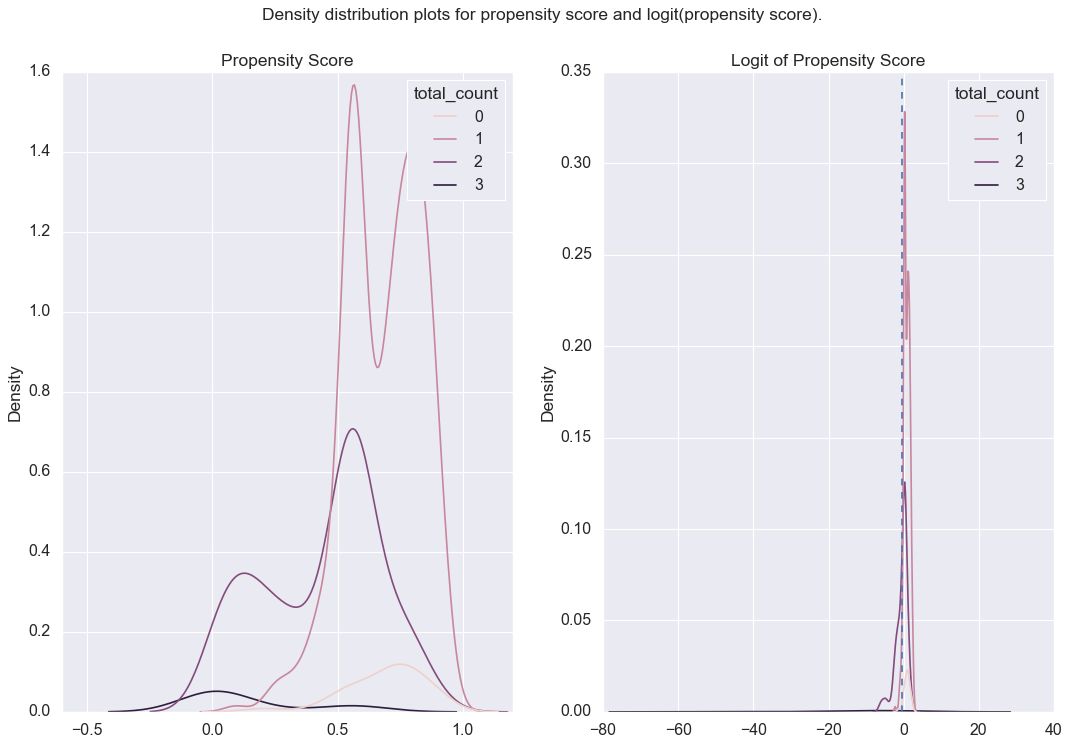


Caliper (radius) is: 0.0578

Spearman correlation: 0.05106723267395223 p-value: 0.22225841545671005
[[  0   0   0   0]
 [  1   0   0   0]
 [  2  72   0   0]
 [ 24 277 196   0]]


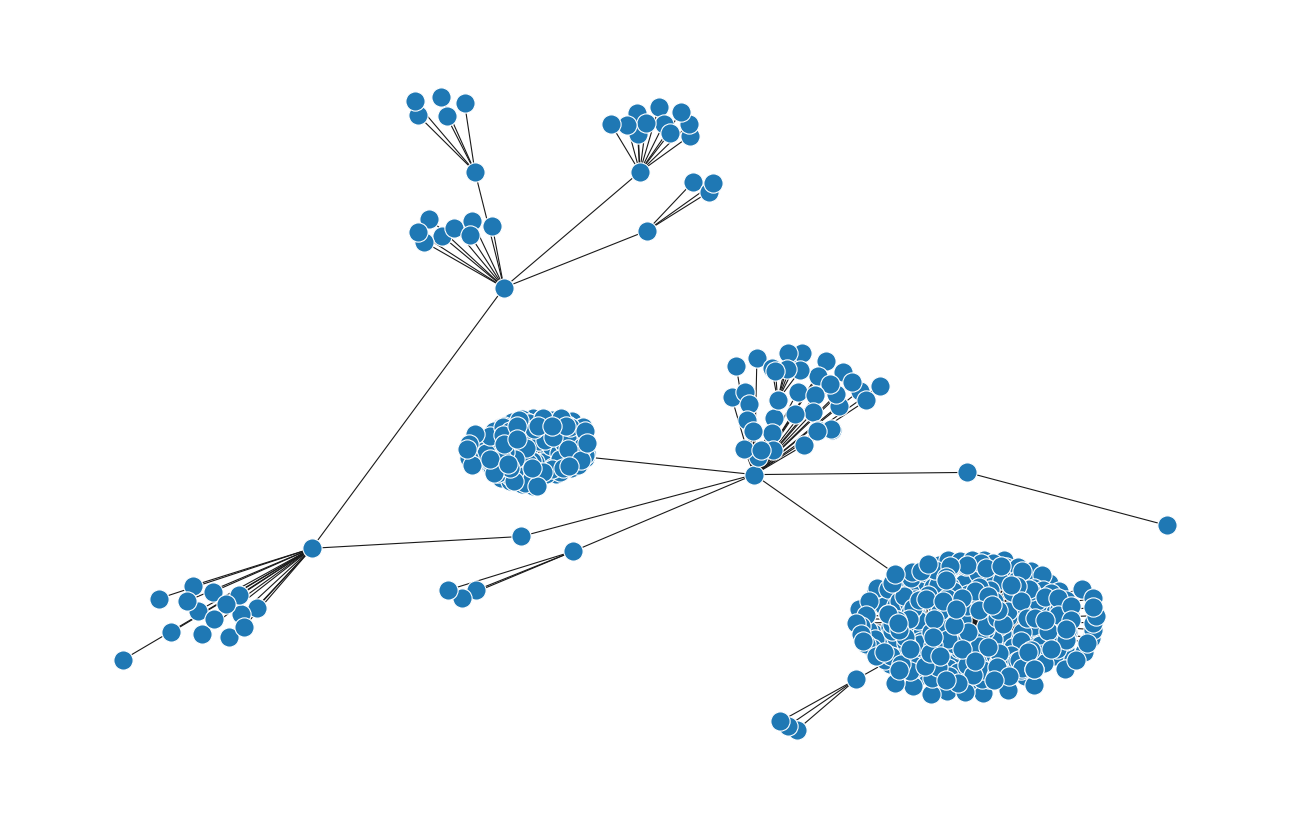

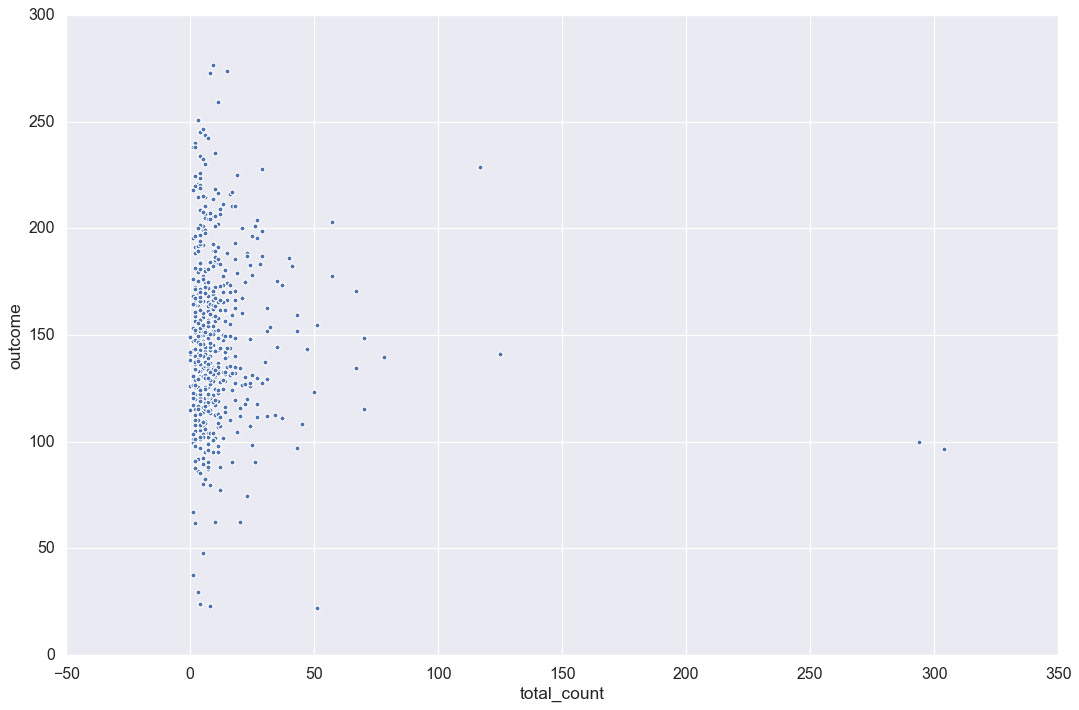

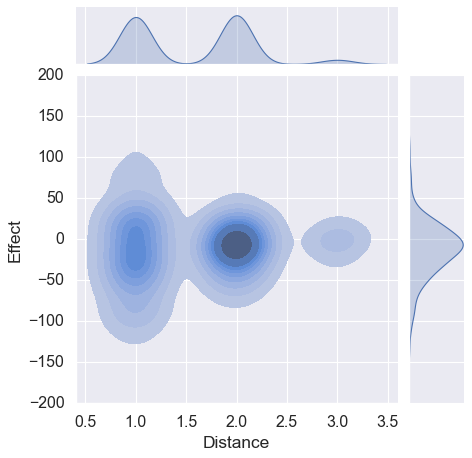

In [12]:
obtain_results(full_dataset_confounders_2015, 'total_count', all_columns_to_drop_year)

# 2016 total

Accuracy: 0.6981

Confusion matrix:
[[  1  25   1   0]
 [  0 307  27   0]
 [  0 112  85   1]
 [  0   3   4   7]]

F1 score is: [0.07142857 0.78617157 0.53968254 0.63636364]


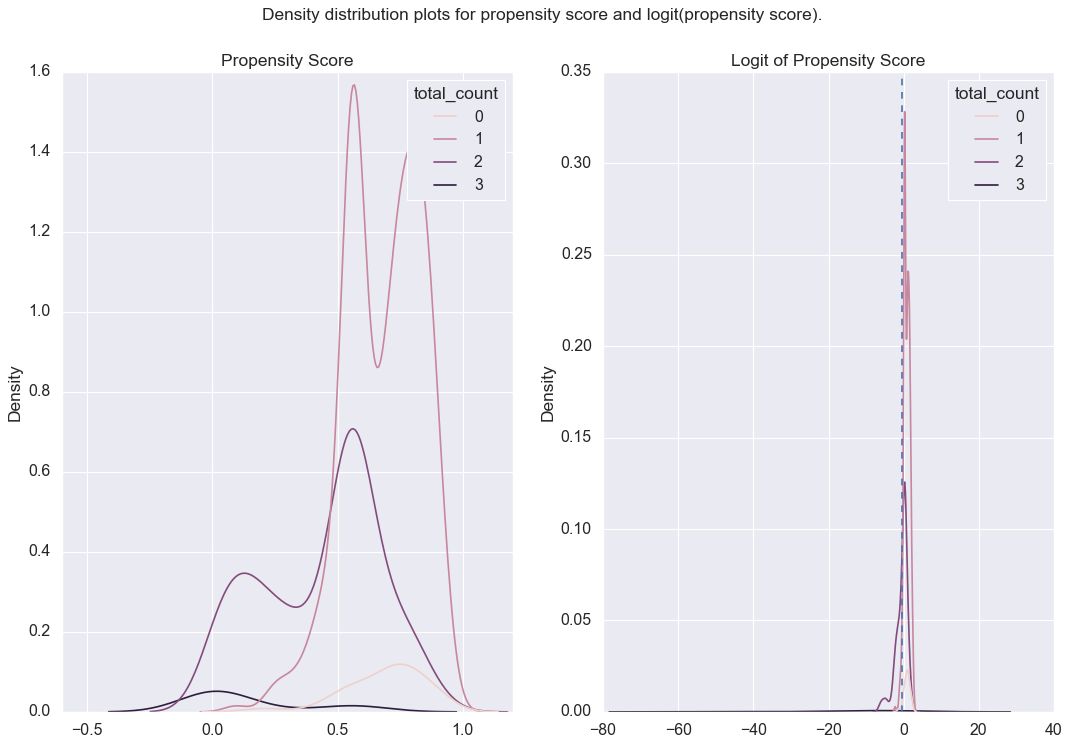


Caliper (radius) is: 0.0578

Spearman correlation: 0.05106723267395223 p-value: 0.22225841545671005
[[  0   0   0   0]
 [  1   0   0   0]
 [  2  72   0   0]
 [ 24 277 196   0]]


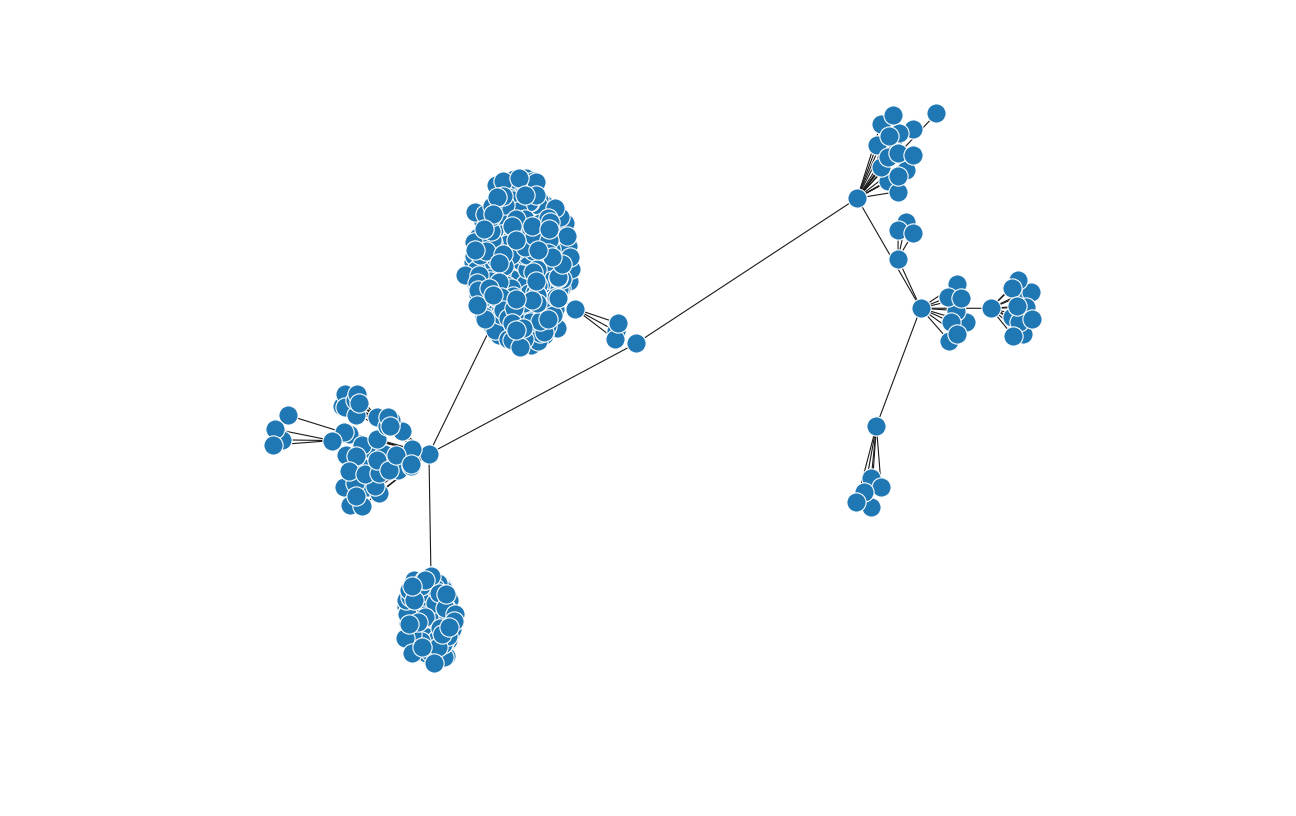

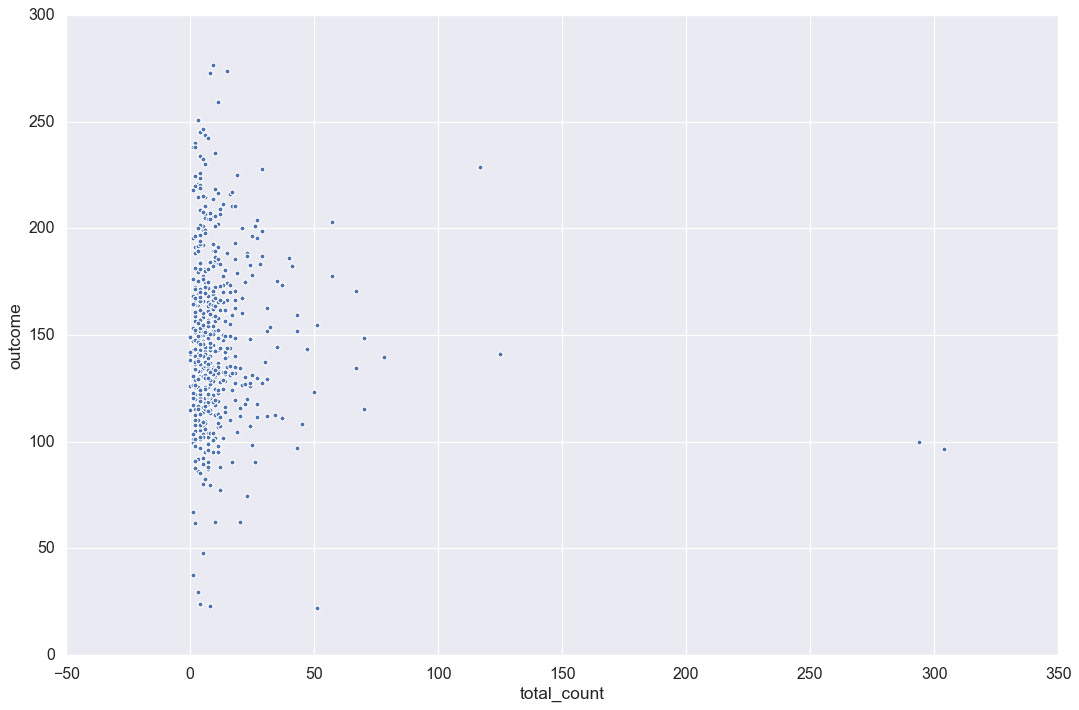

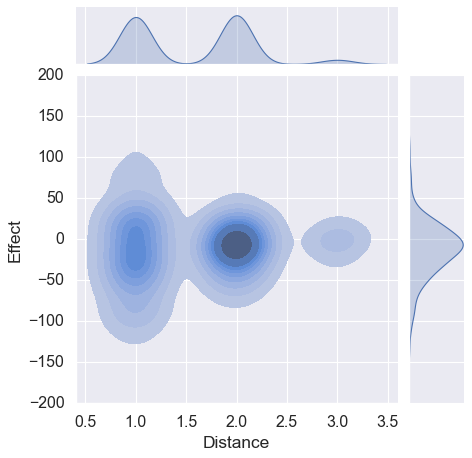

In [13]:
obtain_results(full_dataset_confounders_2016, 'total_count', all_columns_to_drop_year)